In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
# Load dataset
file_path = '/kaggle/input/nlp-getting-started/train.csv'
df = pd.read_csv(file_path)

# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumn Data Types:\n", df.dtypes)

Dataset Shape: (7613, 5)

Column Data Types:
 id           int64
keyword     object
location    object
text        object
target       int64
dtype: object


In [4]:
display(df.head())
df.isnull().sum()
print(df.info())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [5]:
# Reasoned that location column is not particularly relevant, so will remove it altogether
df.drop(columns=['location'], inplace=True)

In [6]:
display(df.head())
df.isnull().sum()
print(df.info())

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       7613 non-null   int64 
 1   keyword  7552 non-null   object
 2   text     7613 non-null   object
 3   target   7613 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 238.0+ KB
None


# Preprocessing data

In [7]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocessing function with lemmatization
def preprocess_text_with_lemmas(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and non-alphanumeric characters
    text = re.sub(f"[{string.punctuation}]", " ", text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize and remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words("english")]
    return " ".join(tokens)

# Apply the function to preprocess the text
df['cleaned_text'] = df['text'].apply(preprocess_text_with_lemmas)

# Vectorize using TF-IDF with n-grams (bigrams in this example)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)  # (1,2) for bigrams
X = vectorizer.fit_transform(df['cleaned_text'])

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Text vectorization

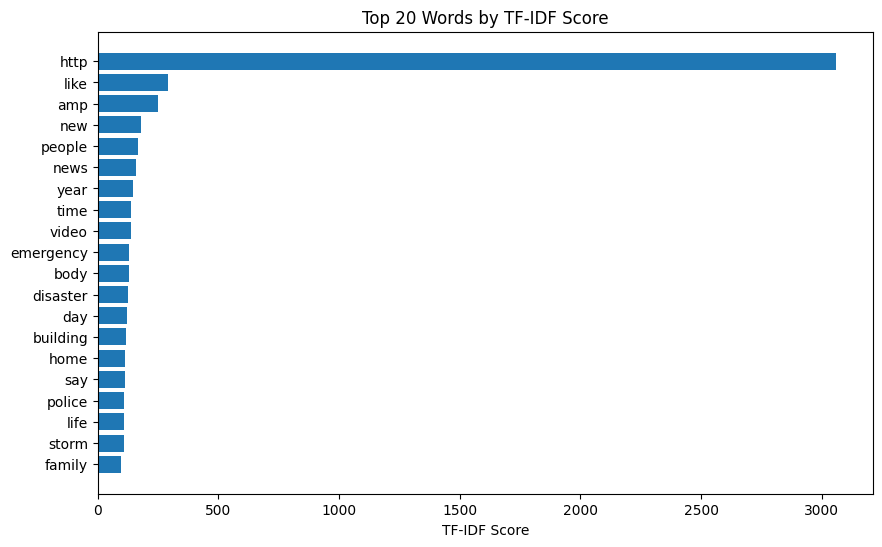

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=20)  # Limit to 20 important features for visualization

# Fit and transform the cleaned text data
X = vectorizer.fit_transform(df['cleaned_text'])

# Get the feature names (words) and their corresponding TF-IDF scores
tfidf_scores = X.sum(axis=0).A1  # Sum the TF-IDF scores for each word
words = vectorizer.get_feature_names_out()

# Create a DataFrame to sort words by TF-IDF score
tfidf_df = pd.DataFrame(list(zip(words, tfidf_scores)), columns=['word', 'tfidf'])
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False)

# Plot the top 20 words by TF-IDF score
plt.figure(figsize=(10, 6))
plt.barh(tfidf_df['word'].head(20), tfidf_df['tfidf'].head(20))
plt.xlabel('TF-IDF Score')
plt.title('Top 20 Words by TF-IDF Score')
plt.gca().invert_yaxis()
plt.show()

## Cosine Simularity

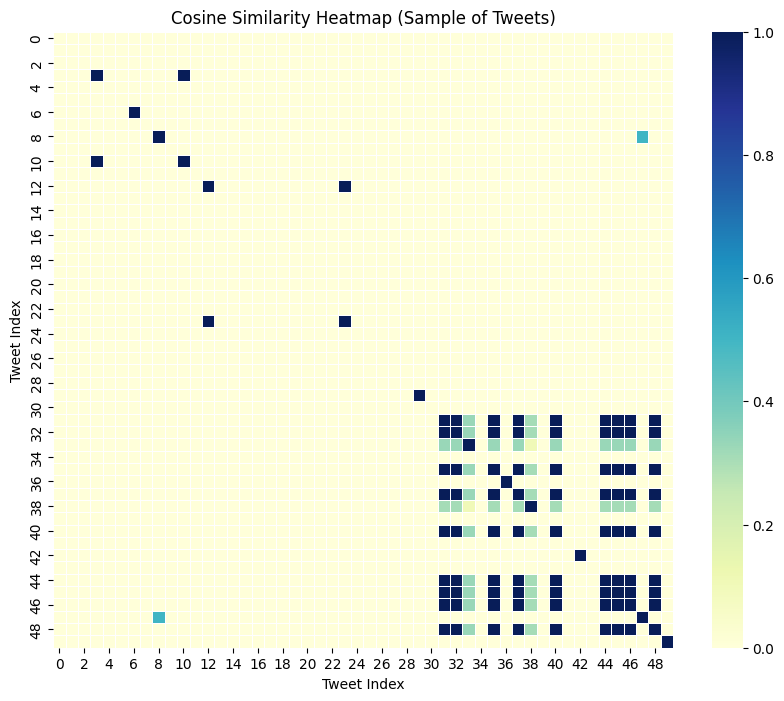

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns


# Calculate the cosine similarity between all pairs of tweets
similarity_matrix = cosine_similarity(X)

# Find the indices of rows where the keyword is missing
missing_keyword_indices = df[df['keyword'].isnull()].index
# Select a smaller sample of the dataset (e.g., first 500 tweets)
sample_size = 50
X_sample = X[:sample_size]

# Calculate the cosine similarity matrix for the sample
similarity_matrix_sample = cosine_similarity(X_sample)

# Visualize the similarity matrix for the sample
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix_sample, cmap='YlGnBu', annot=False, fmt=".2f", linewidths=0.5)
plt.title('Cosine Similarity Heatmap (Sample of Tweets)')
plt.xlabel('Tweet Index')
plt.ylabel('Tweet Index')
plt.show()

# Replacing null keywords

In [10]:
# For each tweet with a missing keyword, find similar tweets
for idx in missing_keyword_indices:
    # Get similarities between this tweet and all other tweets
    similarities = similarity_matrix[idx]
    
    # Find the indices of the most similar tweets (excluding the tweet itself)
    similar_indices = similarities.argsort()[-6:-1]  # Top 5 most similar tweets
    
    # Get the keywords of the most similar tweets
    similar_keywords = df.loc[similar_indices, 'keyword'].dropna()
    
    # If there are any similar keywords, find the most frequent one
    if len(similar_keywords) > 0:
        most_frequent_similar_keyword = similar_keywords.mode()[0]
        df.at[idx, 'keyword'] = most_frequent_similar_keyword

In [11]:
df.drop(columns=['text'], inplace=True)
display(df.head())
df.isnull().sum()
print(df.info())

,id,keyword,target,cleaned_text
0,1,desolation,1,deed reason earthquake may allah forgive u
1,4,desolation,1,forest fire near la ronge sask canada
2,5,desolation,1,resident asked shelter place notified officer ...
3,6,blood,1,13 000 people receive wildfire evacuation orde...
4,7,desolation,1,got sent photo ruby alaska smoke wildfire pour...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            7613 non-null   int64 
 1   keyword       7613 non-null   object
 2   target        7613 non-null   int64 
 3   cleaned_text  7613 non-null   object
dtypes: int64(2), object(2)
memory usage: 238.0+ KB
None


# Training models

In [12]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, df['target'], test_size=0.2, random_state=42)

## Logistic regression

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the model
logreg_model = LogisticRegression(max_iter=1000)

# Train the model
logreg_model.fit(X_train, y_train)

# Make predictions
y_pred_logreg = logreg_model.predict(X_val)

# Evaluate the model
logreg_accuracy = accuracy_score(y_val, y_pred_logreg)
print(f"Logistic Regression Accuracy: {logreg_accuracy:.4f}")

Logistic Regression Accuracy: 0.6586


## Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_val)

# Evaluate the model
rf_accuracy = accuracy_score(y_val, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Random Forest Accuracy: 0.6546


## XGBoost Classifier

In [15]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_val)

# Evaluate the model
xgb_accuracy = accuracy_score(y_val, y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

XGBoost Accuracy: 0.6520


## Suport Vector Machine

In [16]:
from sklearn.svm import SVC

# Initialize the model
svm_model = SVC(kernel='linear')

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_val)

# Evaluate the model
svm_accuracy = accuracy_score(y_val, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy:.4f}")

SVM Accuracy: 0.6553


# Evaluating models

Evaluation for Logistic Regression:
Accuracy: 0.6586
F1 Score: 0.6270
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       874
           1       0.59      0.67      0.63       649

    accuracy                           0.66      1523
   macro avg       0.66      0.66      0.66      1523
weighted avg       0.67      0.66      0.66      1523



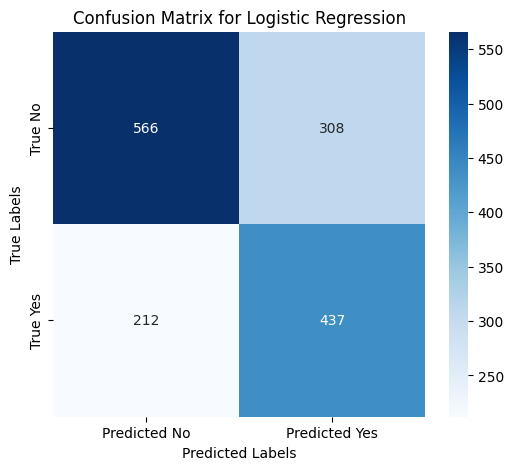

Evaluation for Random Forest:
Accuracy: 0.6546
F1 Score: 0.6221
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       874
           1       0.58      0.67      0.62       649

    accuracy                           0.65      1523
   macro avg       0.65      0.66      0.65      1523
weighted avg       0.66      0.65      0.66      1523



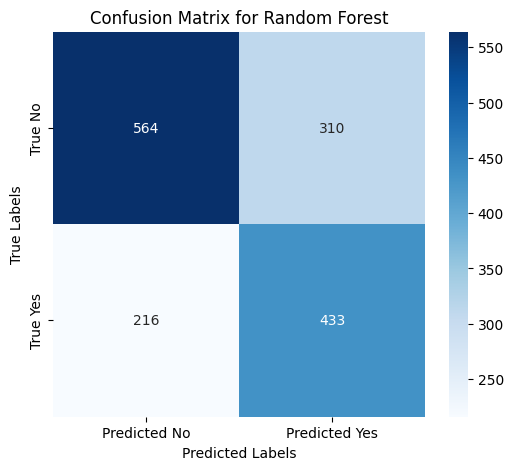

Evaluation for XGBoost:
Accuracy: 0.6520
F1 Score: 0.6165
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       874
           1       0.58      0.66      0.62       649

    accuracy                           0.65      1523
   macro avg       0.65      0.65      0.65      1523
weighted avg       0.66      0.65      0.65      1523



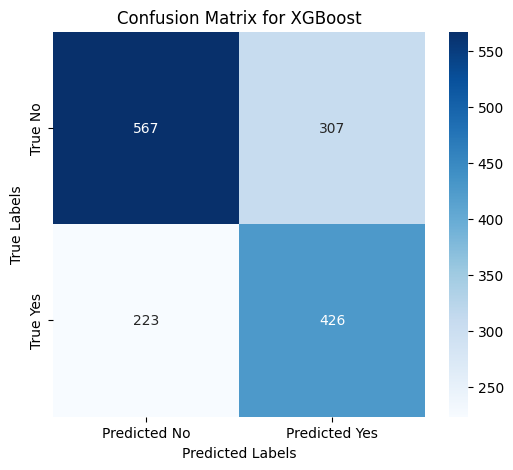

Evaluation for SVM:
Accuracy: 0.6553
F1 Score: 0.6279
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.64      0.68       874
           1       0.58      0.68      0.63       649

    accuracy                           0.66      1523
   macro avg       0.66      0.66      0.65      1523
weighted avg       0.67      0.66      0.66      1523



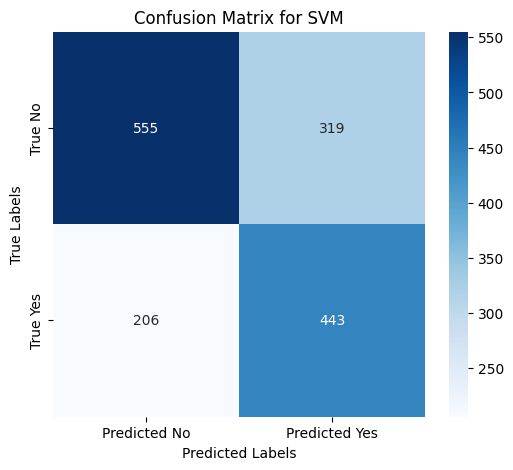

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate a model and plot the confusion matrix
def evaluate_model_with_confusion_matrix(y_true, y_pred, model_name="Model"):
    print(f"Evaluation for {model_name}:")
    
    # Accuracy and F1 Score
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"Classification Report:\n{classification_report(y_true, y_pred)}")
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['True No', 'True Yes'])
    
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    print("="*50)

# Example of using the function for different models

# Logistic Regression Evaluation
y_pred_logreg = logreg_model.predict(X_val)
evaluate_model_with_confusion_matrix(y_val, y_pred_logreg, model_name="Logistic Regression")

# Random Forest Evaluation
y_pred_rf = rf_model.predict(X_val)
evaluate_model_with_confusion_matrix(y_val, y_pred_rf, model_name="Random Forest")

# XGBoost Evaluation
y_pred_xgb = xgb_model.predict(X_val)
evaluate_model_with_confusion_matrix(y_val, y_pred_xgb, model_name="XGBoost")

# Support Vector Machine Evaluation
y_pred_svm = svm_model.predict(X_val)
evaluate_model_with_confusion_matrix(y_val, y_pred_svm, model_name="SVM")

# Hyperparameter tuning

## Logistic Regression

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters for Logistic Regression: {'C': 1, 'solver': 'liblinear'}
Best Cross-validation Score: 0.6481
Evaluation for Best Logistic Regression:
Accuracy: 0.6586
F1 Score: 0.6270
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       874
           1       0.59      0.67      0.63       649

    accuracy                           0.66      1523
   macro avg       0.66      0.66      0.66      1523
weighted avg       0.67      0.66      0.66      1523



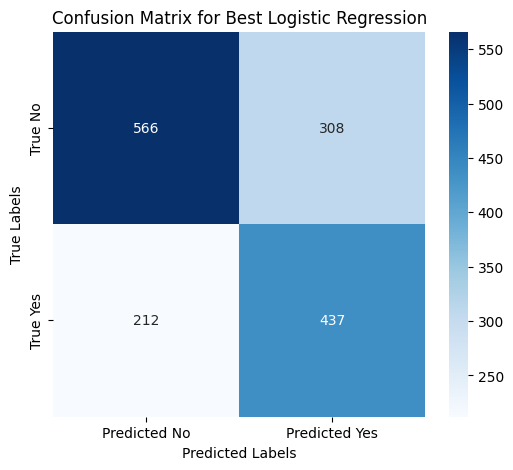

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid for Logistic Regression
param_grid_logreg = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga']  # Optimization algorithms
}

# Initialize GridSearchCV with Logistic Regression
grid_search_logreg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_logreg, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search
grid_search_logreg.fit(X_train, y_train)

# Best parameters and model evaluation
print(f"Best Parameters for Logistic Regression: {grid_search_logreg.best_params_}")
print(f"Best Cross-validation Score: {grid_search_logreg.best_score_:.4f}")

# Retrieve the best model from grid search
best_logreg_model = grid_search_logreg.best_estimator_

# Evaluate the best model
y_pred_best_logreg = best_logreg_model.predict(X_val)
evaluate_model_with_confusion_matrix(y_val, y_pred_best_logreg, model_name="Best Logistic Regression")

## Random Forest

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-validation Score: 0.6521
Evaluation for Best Random Forest:
Accuracy: 0.6559
F1 Score: 0.6225
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       874
           1       0.58      0.67      0.62       649

    accuracy                           0.66      1523
   macro avg       0.65      0.66      0.65      1523
weighted avg       0.66      0.66      0.66      1523



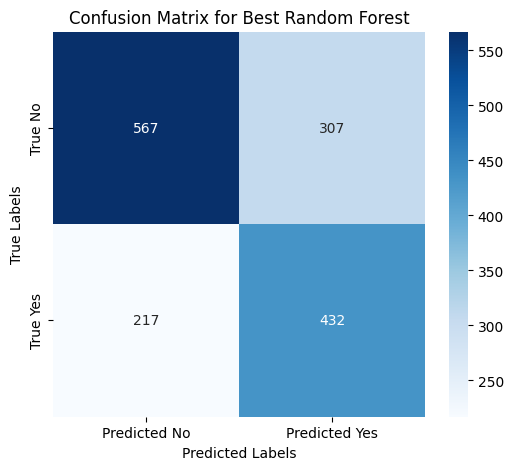

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [10, 20, None],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum samples at a leaf node
}

# Initialize GridSearchCV with RandomForestClassifier
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search
grid_search_rf.fit(X_train, y_train)

# Best parameters and model evaluation
print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best Cross-validation Score: {grid_search_rf.best_score_:.4f}")

# Retrieve the best model from grid search
best_rf_model = grid_search_rf.best_estimator_

# Evaluate the best model
y_pred_best_rf = best_rf_model.predict(X_val)
evaluate_model_with_confusion_matrix(y_val, y_pred_best_rf, model_name="Best Random Forest")

## XGBoost Classifier

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END ............................C=0.1, solver=liblinear; total time=   0.0s
[CV] END .................................C=0.1, solver=saga; total time=   0.0s
[CV] END ..............................C=1, solver=liblinear; total time=   0.0s
[CV] END ..............................C=1, solver=liblinear; total time=   0.0s
[CV] END ...................................C=1, solver=saga; total time=   0.0s
[CV] END .............................C=10, solver=liblinear; total time=   0.0s
[CV] END ..................................C=10, solver=saga; total time=   0.0s
[CV] END ............................C=100, solver=liblinear; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total 

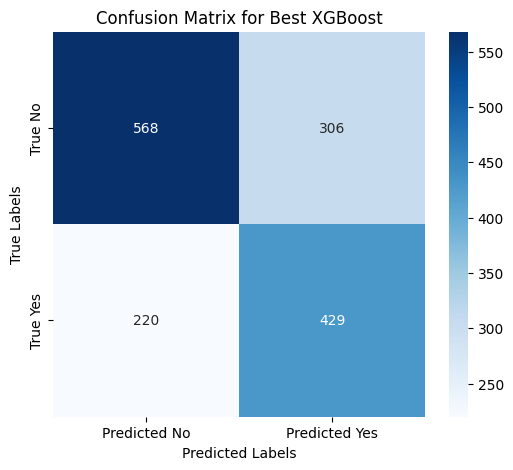

In [20]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],  # Number of trees
    'max_depth': [3, 6, 9],  # Depth of trees
    'learning_rate': [0.01, 0.1, 0.3],  # Learning rate
    'subsample': [0.7, 0.8, 1.0]  # Fraction of samples used for fitting trees
}

# Initialize GridSearchCV with XGBoost
grid_search_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search
grid_search_xgb.fit(X_train, y_train)

# Best parameters and model evaluation
print(f"Best Parameters for XGBoost: {grid_search_xgb.best_params_}")
print(f"Best Cross-validation Score: {grid_search_xgb.best_score_:.4f}")

# Retrieve the best model from grid search
best_xgb_model = grid_search_xgb.best_estimator_

# Evaluate the best model
y_pred_best_xgb = best_xgb_model.predict(X_val)
evaluate_model_with_confusion_matrix(y_val, y_pred_best_xgb, model_name="Best XGBoost")

## Support Vector Machine

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-validation Score: 0.6501
Evaluation for Best SVM:
Accuracy: 0.6632
F1 Score: 0.6312
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       874
           1       0.59      0.68      0.63       649

    accuracy                           0.66      1523
   macro avg       0.66      0.66      0.66      1523
weighted avg       0.67      0.66      0.66      1523



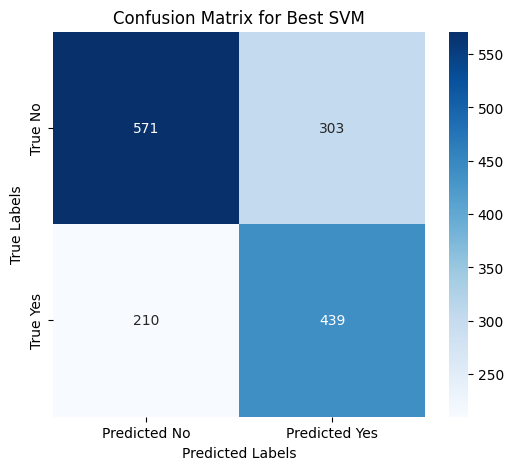

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],  # Regularization strength
    'kernel': ['linear', 'rbf'],  # Types of kernels
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

# Initialize GridSearchCV with SVC
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search
grid_search_svm.fit(X_train, y_train)

# Best parameters and model evaluation
print(f"Best Parameters for SVM: {grid_search_svm.best_params_}")
print(f"Best Cross-validation Score: {grid_search_svm.best_score_:.4f}")

# Retrieve the best model from grid search
best_svm_model = grid_search_svm.best_estimator_

# Evaluate the best model
y_pred_best_svm = best_svm_model.predict(X_val)
evaluate_model_with_confusion_matrix(y_val, y_pred_best_svm, model_name="Best SVM")

# Evaluating best models

Evaluation for Best Logistic Regression:
Accuracy: 0.6586
F1 Score: 0.6270
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       874
           1       0.59      0.67      0.63       649

    accuracy                           0.66      1523
   macro avg       0.66      0.66      0.66      1523
weighted avg       0.67      0.66      0.66      1523



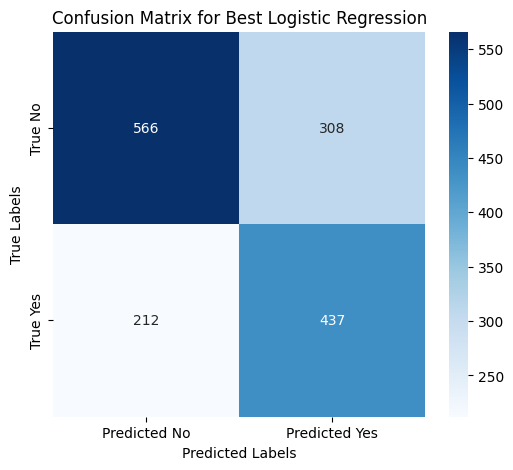

Evaluation for Best Random Forest:
Accuracy: 0.6559
F1 Score: 0.6225
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       874
           1       0.58      0.67      0.62       649

    accuracy                           0.66      1523
   macro avg       0.65      0.66      0.65      1523
weighted avg       0.66      0.66      0.66      1523



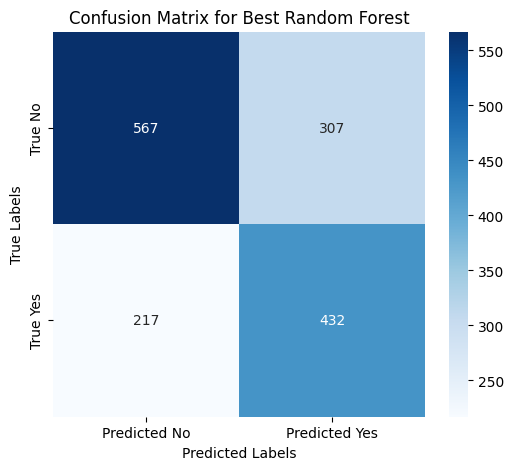

Evaluation for Best XGBoost:
Accuracy: 0.6546
F1 Score: 0.6199
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       874
           1       0.58      0.66      0.62       649

    accuracy                           0.65      1523
   macro avg       0.65      0.66      0.65      1523
weighted avg       0.66      0.65      0.66      1523



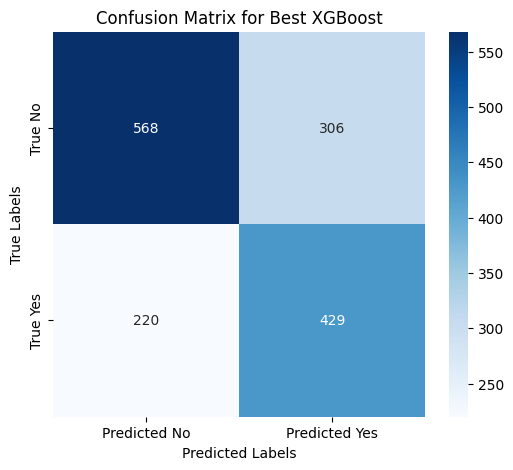

Evaluation for Best SVM:
Accuracy: 0.6632
F1 Score: 0.6312
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       874
           1       0.59      0.68      0.63       649

    accuracy                           0.66      1523
   macro avg       0.66      0.66      0.66      1523
weighted avg       0.67      0.66      0.66      1523



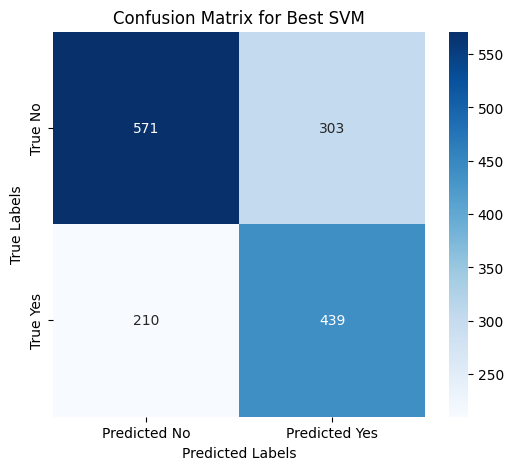

In [22]:
# Best Logistic Regression model
best_logreg_model = grid_search_logreg.best_estimator_
y_pred_best_logreg = best_logreg_model.predict(X_val)
evaluate_model_with_confusion_matrix(y_val, y_pred_best_logreg, model_name="Best Logistic Regression")

# Best Random Forest model
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_val)
evaluate_model_with_confusion_matrix(y_val, y_pred_best_rf, model_name="Best Random Forest")

# Best XGBoost model
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_val)
evaluate_model_with_confusion_matrix(y_val, y_pred_best_xgb, model_name="Best XGBoost")

# Best Support Vector Machine model
best_svm_model = grid_search_svm.best_estimator_
y_pred_best_svm = best_svm_model.predict(X_val)
evaluate_model_with_confusion_matrix(y_val, y_pred_best_svm, model_name="Best SVM")

# Combining models to take the average

## Voting classifier
### Makes final predictions off of the averaged probability of all of the models

Evaluation for Voting Classifier with SVM:
Accuracy: 0.6645
F1 Score: 0.6289
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       874
           1       0.59      0.67      0.63       649

    accuracy                           0.66      1523
   macro avg       0.66      0.66      0.66      1523
weighted avg       0.67      0.66      0.67      1523



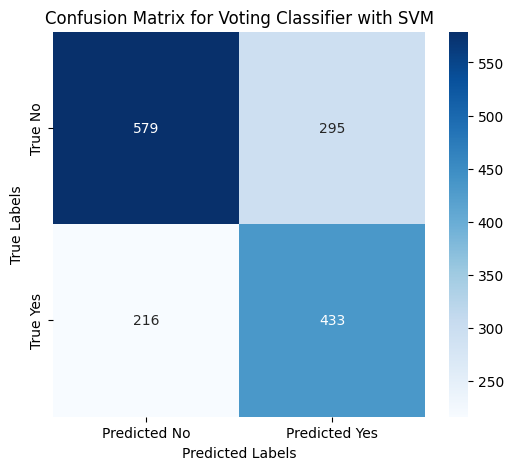

In [28]:
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Add SVM to the list of classifiers
voting_clf = VotingClassifier(
    estimators=[('logreg', best_logreg_model), 
                ('rf', best_rf_model), 
                ('xgb', best_xgb_model),
                ('svm', SVC(probability=True))],  # Add SVM here
    voting='soft'  # 'soft' voting takes the average of predicted probabilities
)

# Fit the voting classifier to the entire training data
voting_clf.fit(X, df['target'])

# Make predictions on the validation data
y_pred_voting = voting_clf.predict(X_val)

# Evaluate the voting classifier
evaluate_model_with_confusion_matrix(y_val, y_pred_voting, model_name="Voting Classifier")

## Stacking classifier
### Should be slightly better than the Voting Classifier

Evaluation for Stacked Model:
Accuracy: 0.6671
F1 Score: 0.6297
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       874
           1       0.60      0.66      0.63       649

    accuracy                           0.67      1523
   macro avg       0.66      0.67      0.66      1523
weighted avg       0.67      0.67      0.67      1523



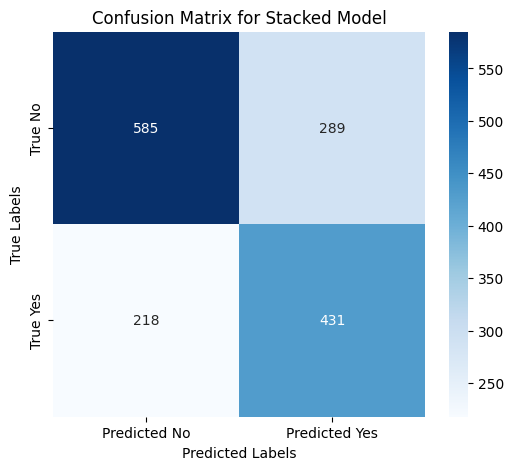

In [29]:
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

# Add SVM to the list of base models
estimators = [
    ('logreg', best_logreg_model), 
    ('rf', best_rf_model), 
    ('xgb', best_xgb_model),
    ('svm', SVC(probability=True))  # Add SVM here
]

# Use a Logistic Regression model as the meta-model (final estimator)
stacked_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Fit the stacked model to the entire training data
stacked_model.fit(X, df['target'])

# Make predictions on the validation data
y_pred_stacked = stacked_model.predict(X_val)

# Evaluate the stacked model
evaluate_model_with_confusion_matrix(y_val, y_pred_stacked, model_name="Stacked Model")

# Submission

In [30]:
best_rf_model = stacked_model
# Step 1: Train the best model on the full training data
best_rf_model.fit(X, df['target'])  # X is the feature matrix, and df['target'] is the target column

# Step 2: Preprocess the test set and vectorize it
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_df.drop(columns=['location'], inplace=True)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text_with_lemmas)  # Apply preprocessing

# Vectorize the test data
X_test = vectorizer.transform(test_df['cleaned_text'])

# Step 3: Predict the target for the test set
y_pred_test = best_rf_model.predict(X_test)

# Step 4: Create the submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],  # The 'id' column from the test set
    'target': y_pred_test  # The predicted target
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

NameError: name 'preprocess_text' is not defined